In [18]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# данные из двух столбцов

data = pd.read_csv('water.csv')[['mortality', 'hardness']]
data.head()

,mortality,hardness
0,1247,105
1,1668,17
2,1466,5
3,1800,14
4,1609,18


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   mortality  61 non-null     int64
 1   hardness   61 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


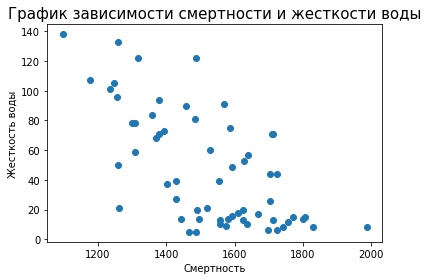

In [26]:
# точечный график зависимости смертности и жесткости воды


plt.scatter(data['mortality'], data['hardness'])



plt.title("График зависимости смертности и жесткости воды", size=15)
plt.ylabel('Жесткость воды', size = 10) 
plt.xlabel('Смертность', size = 10) 
plt.show()

**Для начала выявлю, есть ли выбросы.**

In [28]:
q1 = data['mortality'].quantile(0.25)
q3 = data['mortality'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)
remove_outliers = data[data['mortality'].between(lower_bound, upper_bound, inclusive=True)].sort_values('mortality')
print(remove_outliers)

    mortality  hardness
25       1096       138
37       1175       107
41       1236       101
0        1247       105
14       1254        96
..        ...       ...
28       1772        15
3        1800        14
6        1807        15
29       1828         8
45       1987         8

[61 rows x 2 columns]


**Выбросов в данных по смертности нет. Далее посчитан коэффициент корреляции.**

In [30]:
# Корреляция Пирсона

data[['mortality', 'hardness']].corr()

,mortality,hardness
mortality,1.000000,-0.654849
hardness,-0.654849,1.000000


In [31]:
# Корреляция Спирмена

data[['mortality', 'hardness']].corr(method='spearman')

,mortality,hardness
mortality,1.000000,-0.631665
hardness,-0.631665,1.000000


**Коэффициенты корреляции Пирсона и Спирмена очень близки. По этим значениям, могу сказать, что наблюдается средняя обратная зависимость.**

**Ниже построение модели линейной регрессии. Регрессия - предсказание одной переменной на основании другой, в нашем случае предсказание смертности на основании величины жесткости воды.**

In [9]:
# 1ый способ 

from sklearn.linear_model import LinearRegression

In [10]:
X = data[['mortality']].values
Y = data['hardness'].values

In [11]:
X.shape

(61, 1)

In [12]:
Y.shape

(61,)

In [13]:
# model.score - коэффициент детерминации, то есть доля дисперсии зависимой переменной.

model = LinearRegression()
model.fit(X, Y)
model.score(X, Y)

0.4288267193124973

**Чем ближе коэффициент детерминации к 1, тем сильнее зависимость. В случае коэффициента детерминации, рассчитанного выше, можно сказать, что в 43 процентах изменение жесткости воды ведет к изменению смертности.**

In [15]:
# параметр, который задается, если данные не отцентрированы. 

model.intercept_

249.77692756960676

**Что показывает intercept? Примерное значение в 249,8 показывает, что наша модель предсказывает этот ответ при жесткости воды равной нулю.**

**А коэффициент, рассчитанный ниже, показывает, на сколько изменяется предсказанный ответ при изменении жесткости воды на единицу.**

In [14]:
model.coef_

array([-0.13292453])

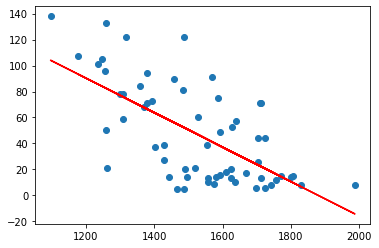

In [16]:
plt.scatter(data['mortality'], data['hardness'])
plt.plot(data['mortality'], model.predict(data[['mortality']]), c='r')

In [32]:
# 2ой способ построения регрессии (statsmodel)

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [33]:
X = sm.add_constant(X)

In [34]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     44.30
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           1.03e-08
Time:                        18:20:15   Log-Likelihood:                -291.01
No. Observations:                  61   AIC:                             586.0
Df Residuals:                      59   BIC:                             590.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        249.7769     30.666      8.145      0.0

**С вероятностью до 95% с уменьшением жесткости воды на единицу смертность растет в диапазоне от 188 до 311 человек.**

In [35]:
# коэффициент детерминации

print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  [ 2.49776928e+02 -1.32924533e-01]
R2:  0.42882671931249716


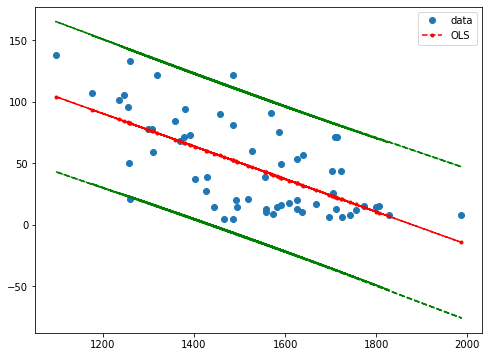

In [36]:
prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X[:,1], Y, 'o', label="data")
ax.plot(X[:,1], results.fittedvalues, 'r--.', label="OLS")
ax.plot(X[:,1], iv_u, 'g--')
ax.plot(X[:,1], iv_l, 'g--')
ax.legend(loc='best');

**Остатки ведут себя достаточно хаотично**

(array([ 2.,  3., 11., 10.,  9.,  9.,  8.,  3.,  5.,  1.]),
 array([-61.29201633, -48.18792189, -35.08382745, -21.97973301,
         -8.87563857,   4.22845587,  17.33255031,  30.43664475,
         43.54073919,  56.64483363,  69.74892807]),
 <a list of 10 Patch objects>)

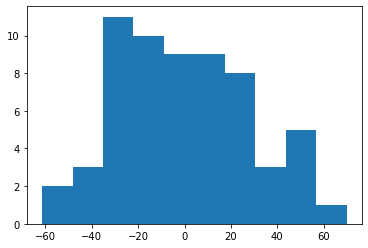

In [37]:
plt.hist(results.resid)

**Как итог. Зависимость есть, но назвать ее особо точной я не могу, величина ошибки в диапазоне от -60 до 60 процентов.**

**А как изменится зависимость, если данные разделить на две группы в зависимости от локации?**

In [38]:
df = pd.read_csv('water.csv')
df.head()

,Unnamed: 0,location,town,mortality,hardness
0,1,South,Bath,1247,105
1,2,North,Birkenhead,1668,17
2,3,South,Birmingham,1466,5
3,4,North,Blackburn,1800,14
4,5,North,Blackpool,1609,18


In [40]:
df_north = df[df.location=='North'][['mortality', 'hardness']]
df_north.head()

,mortality,hardness
1,1668,17
3,1800,14
4,1609,18
5,1558,10
6,1807,15


In [41]:
df_south = df[df.location=='South'][['mortality', 'hardness']]
df_south.head()

,mortality,hardness
0,1247,105
2,1466,5
7,1299,78
9,1359,84
10,1392,73


In [46]:
# Корреляция Пирсона для северного направления

df_north[['mortality', 'hardness']].corr()

,mortality,hardness
mortality,1.000000,-0.368598
hardness,-0.368598,1.000000


In [47]:
# Корреляция Пирсона для южного направления

df_south[['mortality', 'hardness']].corr()

,mortality,hardness
mortality,1.000000,-0.602153
hardness,-0.602153,1.000000


**Зависимость между жесткостью воды и смертностью в северных регионах слабее выражена по сравнению с суммарной, в то время как в южных регионах она сильнее. Последнюю и рассмотрю подробнее.**

In [50]:
df_south.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   mortality  26 non-null     int64
 1   hardness   26 non-null     int64
dtypes: int64(2)
memory usage: 624.0 bytes


In [52]:
q1 = df_south['mortality'].quantile(0.25)
q3 = df_south['mortality'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)
remove_outliers = df_south[df_south['mortality'].between(lower_bound, upper_bound, inclusive=True)].sort_values('mortality')
print(remove_outliers.count())

mortality    26
hardness     26
dtype: int64


**Выбросов нет.**

In [48]:
X = df_south[['mortality']].values
Y = df_south['hardness'].values

model = LinearRegression()
model.fit(X, Y)
model.score(X, Y)

0.3625885624364601

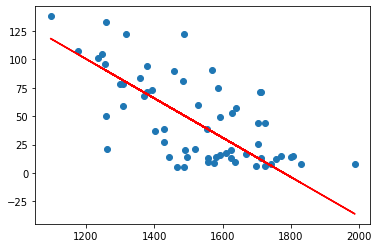

In [49]:
plt.scatter(data['mortality'], data['hardness'])
plt.plot(data['mortality'], model.predict(data[['mortality']]), c='r')

In [54]:
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     13.65
Date:                Sun, 20 Sep 2020   Prob (F-statistic):            0.00113
Time:                        20:14:37   Log-Likelihood:                -126.67
No. Observations:                  26   AIC:                             257.3
Df Residuals:                      24   BIC:                             259.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        308.3177     64.883      4.752      0.0

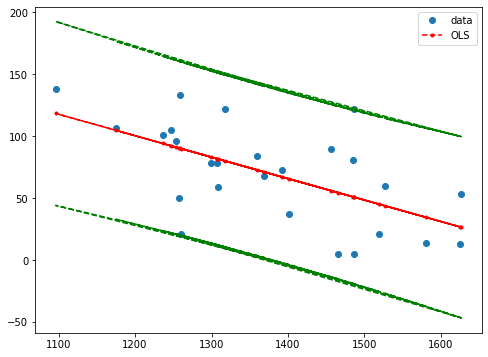

In [55]:
prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X[:,1], Y, 'o', label="data")
ax.plot(X[:,1], results.fittedvalues, 'r--.', label="OLS")
ax.plot(X[:,1], iv_u, 'g--')
ax.plot(X[:,1], iv_l, 'g--')
ax.legend(loc='best');

(array([1., 2., 2., 4., 3., 6., 3., 4., 0., 1.]),
 array([-69.00756398, -54.99184301, -40.97612203, -26.96040106,
        -12.94468009,   1.07104088,  15.08676186,  29.10248283,
         43.1182038 ,  57.13392477,  71.14964575]),
 <a list of 10 Patch objects>)

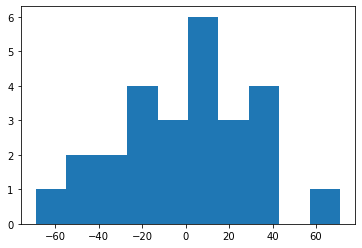

In [56]:
plt.hist(results.resid)